# DSC410: Model Tuning
---

**Name**: Joseph Choi <br>
**Class**: DSC410-T301 Predictive Analytics (2243-1)

#### Instructions:
- Create a regression model that can predict profit
- Report relevant metrics for this type of model (again, this is a regression problem so use regression evaluation metrics)
- Hyperparameter tune the model with cross-fold validation 

#### Keep in mind:
- The data is raw. You need to perform EDA and feature engineering
- You don't need to get fancy with the algorithm selection, but you're welcome to do so
- You must calculate at least two (2) evaluation metrics
- Be cautious with the hyperparameter tuning; demonstrate tuning, don't try to be exhaustive

In [81]:
# Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [6]:
# Loading startups_profit dataset and displaying results

startups_profit_df = pd.read_csv('startups_profit.csv')
startups_profit_df.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,"$192,261.83"
1,162597.70,151377.59,443898.53,California,"$191,792.06"
2,153441.51,101145.55,407934.54,FL,"$191,050.39"


In [8]:
# Displaying summary

startups_profit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4    Profit          50 non-null     object 
dtypes: float64(3), object(2)
memory usage: 2.1+ KB


In [22]:
# Creating a copy of dataset to perform cleaning, transforming, and feature engineering procedures

startups_profit_copy1 = startups_profit_df.copy()

## Data Cleaning:
- Standardizing the **State** column (New York to NY & California to CA)
- Removing whitespace from column names
- Removing '$', commas, and whitespace from **Profit** column to convert column to float 
- Handling '0' values in **R&D Spend** and **Marketing Spend** columns
    - Replacing '0' with the mean of the column partitioned by State

In [23]:
# Standardizing the State column (New York to NY & California to CA)
state_mapping = {'New York': 'NY', 'California': 'CA', 'FL': 'FL'}
startups_profit_copy1['State'] = startups_profit_copy1['State'].replace(state_mapping)

# Printing updated result:
startups_profit_copy1.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,NY,"$192,261.83"
1,162597.70,151377.59,443898.53,CA,"$191,792.06"
2,153441.51,101145.55,407934.54,FL,"$191,050.39"


In [24]:
# Removing whitespace from column names
startups_profit_copy1.columns = startups_profit_copy1.columns.str.strip()

In [25]:
# Removing '$', commas, and whitespace from **Profit** column to convert column to float
startups_profit_copy1['Profit'] = startups_profit_copy1['Profit'].str.replace(' ', '').str.replace(',', '').str.replace('$', '').astype('float64')

In [28]:
# Printing updated result:
startups_profit_copy1.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,NY,192261.83
1,162597.70,151377.59,443898.53,CA,191792.06
2,153441.51,101145.55,407934.54,FL,191050.39


In [29]:
# Displaying updated summary
startups_profit_copy1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [32]:
# Replacing '0' with the mean of the column partitioned by 'State'
startups_profit_copy1['R&D Spend'] = startups_profit_copy1.groupby('State')['R&D Spend'].transform(lambda x: x.replace(0, x.mean()))
startups_profit_copy1['Marketing Spend'] = startups_profit_copy1.groupby('State')['Marketing Spend'].transform(lambda x: x.replace(0, x.mean()))

# Printing updated result:
startups_profit_copy1.head(3)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,NY,192261.83
1,162597.70,151377.59,443898.53,CA,191792.06
2,153441.51,101145.55,407934.54,FL,191050.39


## EDA:
- Plotting histograms for numeric columns and a bar chart for categorical column
- Plotting scatter plots between numerical features and the target variable

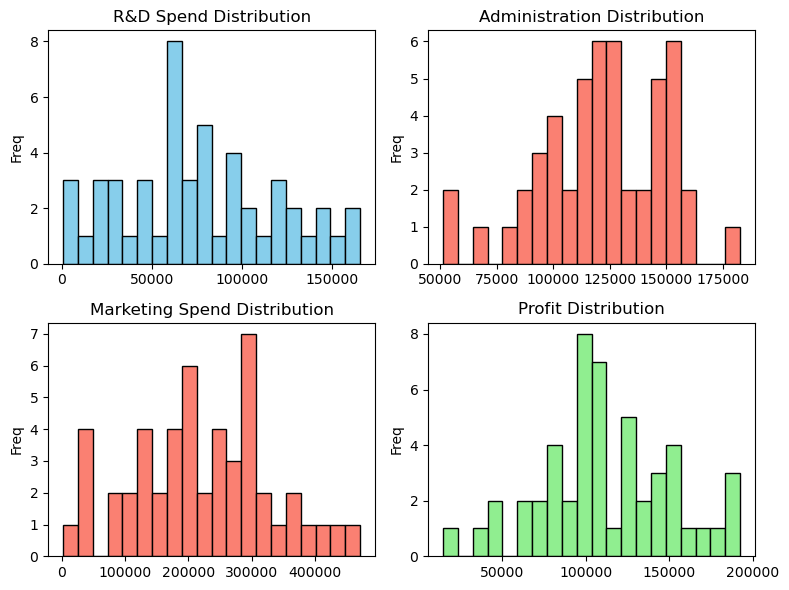

In [45]:
# Plotting histograms for numeric columns

# Subplots for 'R&D Spend', 'Administration', 'Marketing Spend', and 'State' columns
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# 'R&D Spend' Distribution:
axes[0, 0].hist(startups_profit_copy1['R&D Spend'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('R&D Spend Distribution')
axes[0, 0].set_ylabel('Freq')

# 'Administration' Distribution:
axes[0, 1].hist(startups_profit_copy1['Administration'], bins=20, color='salmon', edgecolor='black')
axes[0, 1].set_title('Administration Distribution')
axes[0, 1].set_ylabel('Freq')

# 'Marketing Spend' Distribution:
axes[1, 0].hist(startups_profit_copy1['Marketing Spend'], bins=20, color='salmon', edgecolor='black')
axes[1, 0].set_title('Marketing Spend Distribution')
axes[1, 0].set_ylabel('Freq')

# 'Profit' Distribution:
axes[1, 1].hist(startups_profit_copy1['Profit'], bins=20, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Profit Distribution')
axes[1, 1].set_ylabel('Freq')

# Printing the visualizations
plt.tight_layout()
plt.show()

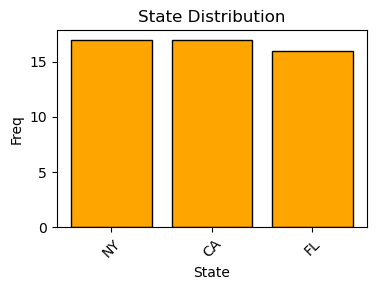

In [54]:
# Plotting bar chart for the 'State' column
plt.figure(figsize=(4, 3))

state_counts = startups_profit_copy1['State'].value_counts()
plt.bar(state_counts.index, state_counts, color='orange', edgecolor='black')
plt.title('State Distribution')
plt.xlabel('State')
plt.ylabel('Freq')
plt.xticks(rotation=45)

# Printing the visualization
plt.tight_layout()
plt.show()

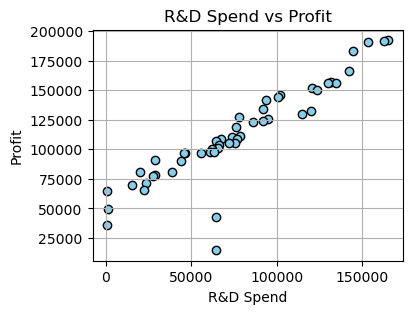

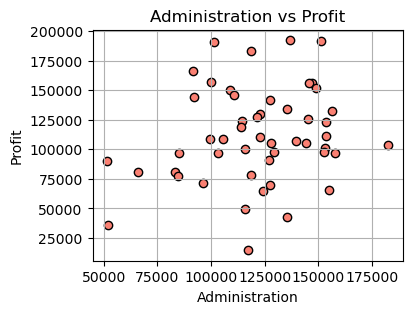

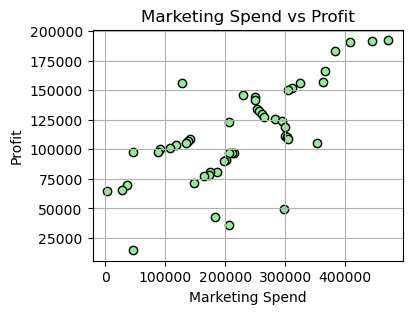

In [56]:
# Scatter plots between numerical features and the target variable

# 'R&D Spend' vs 'Profit'
plt.figure(figsize=(4, 3))
plt.scatter(startups_profit_copy1['R&D Spend'], startups_profit_copy1['Profit'], color='skyblue', edgecolor='black')
plt.title('R&D Spend vs Profit')
plt.xlabel('R&D Spend')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# 'Administration' vs 'Profit'
plt.figure(figsize=(4, 3))
plt.scatter(startups_profit_copy1['Administration'], startups_profit_copy1['Profit'], color='salmon', edgecolor='black')
plt.title('Administration vs Profit')
plt.xlabel('Administration')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# 'Marketing Spend' vs 'Profit'
plt.figure(figsize=(4, 3))
plt.scatter(startups_profit_copy1['Marketing Spend'], startups_profit_copy1['Profit'], color='lightgreen', edgecolor='black')
plt.title('Marketing Spend vs Profit')
plt.xlabel('Marketing Spend')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

# Output: Positive relationships throughout plots

## Feature Engineering:
- One-hot encoding for **State** column

In [60]:
# One-hot encoding for State column
startups_profit_encoded = pd.get_dummies(startups_profit_copy1, columns=['State'])

# Printing updated result
startups_profit_encoded.head(3)

,R&D Spend,Administration,Marketing Spend,Profit,State_CA,State_FL,State_NY
0,165349.20,136897.80,471784.10,192261.83,False,False,True
1,162597.70,151377.59,443898.53,191792.06,True,False,False
2,153441.51,101145.55,407934.54,191050.39,False,True,False


## Model Training:
- **Regression Model**: KNN

In [195]:
# Setting up X and y

# X: R&D Spend, Administration, Marketing Spend, State_CA, State_FL, State_NY
# Y: Profit

X = startups_profit_encoded.drop('Profit', axis=1)
y = startups_profit_encoded['Profit']

In [196]:
# Splitting the data into training and testing sets

# 80% of the entire dataset is dedicated to training (X_train and y_train)
# 20% of the entire dataset is dedicated to testing (X_test and y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
# Initializing and training a KNN regression model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [198]:
# Printing mse (mean squared error)
mse

663310100.4209768

In [199]:
# Printing r2 (r-squared)
r2

0.18088837620619636

## Model Tuning:
- Performing hyperparameter tuning using cross-fold validation
- **Objective**: Select optimal # of neighbors (n_neighbors) based on MAE metric
- Visualize plot and optimal hyperparameter value displayed

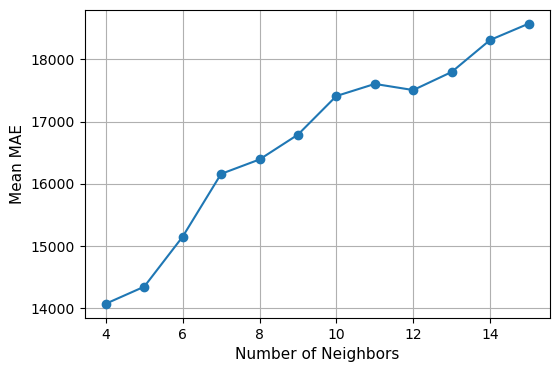

In [200]:
"""
Code Description:
    - Hyperparameter tuning using cross-validation
    - Plotting the MAE against the number of neighbors
    - Identify optimal value (lowest point of MAE)

Code Breakdown:
    - 1st Part: Defining hyperparameter candidates
        - 'n_neighbors': key representing the hyperparameter (KNN)
        - 'np.arange(4, 16)': Creating an array of values from 4 to 15 as value
    - 2nd Part: Initializing the model with specified parameters
        - 'weight=distance': Specifies weight function used in prediction (closer neighbors will have more influence)
        - 'metric=minkowski': Specifies distance metric used to calc distance between points
        - 'leaf_size=50': Specifies Size of the leaf nodes
        - 'n_jobs=4': Specifies the # of parallel jobs
    - 3rd Part: Performing 10-fold cross-validation
    - 4th Part: Printing the visualization
"""

# 1st Part:
hp_candidates = {'n_neighbors': np.arange(4, 16)}

# 2nd Part:
knn_model = KNeighborsRegressor(weights='distance', metric='minkowski', leaf_size=50, n_jobs=4)

# 3rd Part:
mean_mae = [] # Initialize empty list to store mean
std_mae = [] # Initialize empty list to store standard deviation
for param_value in hp_candidates['n_neighbors']: # Looping over values of 'n_neighbors' in 'hp_candidates'
    knn_model.set_params(n_neighbors=param_value) # Sets the 'n_neighbors' for the KNN model to the current valued specified by 'param_value'
    cv_results = cross_val_score(knn_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=10) # Performs 10-fold cross-validation
    mean_score, std_score = -1 * cv_results.mean(), cv_results.std() # Calculates the mean and standard deviation of the mae (negative sign is applied to convert back to the original scale)
    mean_mae.append(mean_score) # Append calculated mean
    std_mae.append(std_score) # Append calculated standard deviation

# 4th Part:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(hp_candidates['n_neighbors'], mean_mae, "o-")
ax.set_xlabel('Number of Neighbors', fontsize=11)
ax.set_ylabel('Mean MAE', fontsize=11)
ax.grid()

**Output**: Best value for K is 4 (lowest MAE point)

## Model Training (Optimal):

In [201]:
# Initializing and training a KNN regression model
knn_model_optimal = KNeighborsRegressor(n_neighbors=4)
knn_model_optimal.fit(X_train, y_train)

# Predicting on the test set
y_pred_optimal = knn_model_optimal.predict(X_test)

# Evaluating the model
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)

In [202]:
# Printing mse (optimal)
mse_optimal

484985779.5182956

In [203]:
# Printing r2 (optimal)
r2_optimal

0.4010983865223655